<a href="https://colab.research.google.com/github/tanpinray/ELEC0134-AMLS-CW/blob/main/Task_B_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import pandas as pd
import numpy as np
import os
import shutil
import random
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from skimage.io import imread, imsave, imshow
import imgaug.augmenters as iaa
from skimage.exposure import equalize_adapthist, equalize_hist

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Sequential, Model

from sklearn import svm, metrics

In [ ]:
# # For google colab
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Train and Validation dataset

In [116]:
def hist_equalizing(image):
    '''
    Inputs
        images_pixelData: Dataset of image pixel data.

    Return
       filtered: A list of HOG features for each image.
    '''

    equalized_img = equalize_adapthist(
        image, clip_limit=0.03, nbins=256)
    
    equalized_img = (equalized_img*255).astype(np.uint8)

    return equalized_img

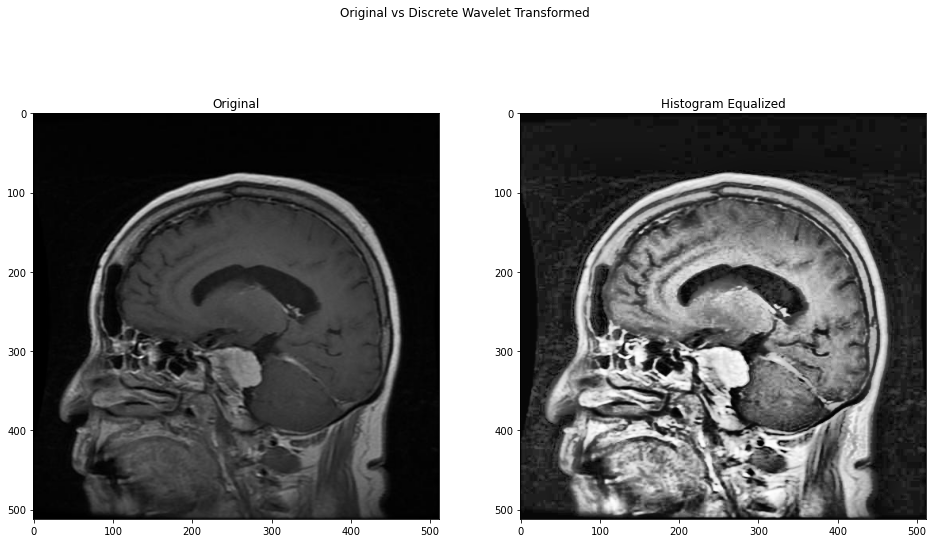

In [117]:
im = imread('./dataset/image/IMAGE_0000.jpg')
equalized_img = equalize_adapthist(im, clip_limit=0.03, nbins=256)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
fig.suptitle('Original vs Discrete Wavelet Transformed')
axs[0].set_title('Original')
axs[0].imshow(im)
axs[1].set_title('Histogram Equalized')
axs[1].imshow(equalized_img)


In [107]:
# # For google colab
# train_path = '/content/drive/My Drive/dataset'
# train_datapath = '/content/drive/My Drive/dataset/image'
# # New path for seperating images into respective classes
# new_train_path = os.path.join(train_path, 'image_classes')

## For offline use
train_path = './dataset'
train_datapath = './dataset/image'
# New path for seperating images into respective classes
new_train_path = os.path.join(train_path, 'image_classes')

# Read csv file with image name and associated labels
df_train = pd.read_csv(os.path.join(train_path, 'label.csv'))

if os.path.exists(new_train_path):
    print('The directory with images sorted by classes already exists')
else:
    os.mkdir(new_train_path)
    for label in df_train['label'].unique():
        os.mkdir(os.path.join(new_train_path, label))

    for filename in tqdm(df_train['file_name']):
        idx = df_train.index[df_train['file_name'] == filename].item()
        if df_train.loc[idx, 'label'] == 'no_tumor':
            shutil.copy(os.path.join(train_datapath, filename),
                        os.path.join(new_train_path, 'no_tumor'))
        elif df_train.loc[idx, 'label'] == 'glioma_tumor':
            shutil.copy(os.path.join(train_datapath, filename),
                        os.path.join(new_train_path, 'glioma_tumor'))
        elif df_train.loc[idx, 'label'] == 'meningioma_tumor':
            shutil.copy(os.path.join(train_datapath, filename),
                        os.path.join(new_train_path, 'meningioma_tumor'))
        elif df_train.loc[idx, 'label'] == 'pituitary_tumor':
            shutil.copy(os.path.join(train_datapath, filename),
                        os.path.join(new_train_path, 'pituitary_tumor'))

  0%|          | 0/3000 [00:00<?, ?it/s]

In [118]:
clahe_train_path = os.path.join(train_path, 'image_classes_clahe')

clahe_no_tumor_path = os.path.join(clahe_train_path, 'no_tumor')
clahe_glioma_tumor_path = os.path.join(clahe_train_path, 'glioma_tumor')
clahe_meningioma_tumor_path = os.path.join(clahe_train_path, 'meningioma_tumor')
clahe_pituitary_tumor_path = os.path.join(clahe_train_path, 'pituitary_tumor')

if os.path.exists(clahe_train_path):
    print('The directory with CLAHEd images sorted by classes already exists')
else:
    os.mkdir(clahe_train_path)
    for label in df_train['label'].unique():
        os.mkdir(os.path.join(clahe_train_path, label))

    for filename in tqdm(df_train['file_name']):
        idx = df_train.index[df_train['file_name'] == filename].item()
        if df_train.loc[idx, 'label'] == 'no_tumor':
            im = imread(os.path.join(train_datapath, filename))
            clahe_im = hist_equalizing(im)
            imsave(os.path.join(clahe_no_tumor_path, filename), clahe_im)
        elif df_train.loc[idx, 'label'] == 'glioma_tumor':
            im = imread(os.path.join(train_datapath, filename))
            clahe_im = hist_equalizing(im)
            imsave(os.path.join(clahe_glioma_tumor_path, filename), clahe_im)
        elif df_train.loc[idx, 'label'] == 'meningioma_tumor':
            im = imread(os.path.join(train_datapath, filename))
            clahe_im = hist_equalizing(im)
            imsave(os.path.join(clahe_meningioma_tumor_path, filename), clahe_im)
        elif df_train.loc[idx, 'label'] == 'pituitary_tumor':
            im = imread(os.path.join(train_datapath, filename))
            clahe_im = hist_equalizing(im)
            imsave(os.path.join(clahe_pituitary_tumor_path, filename), clahe_im)

  0%|          | 0/3000 [00:00<?, ?it/s]

# Data Augmentation

In [119]:
# New path for seperating images into respective classes
aug_train_path = os.path.join(train_path, 'image_classes_aug')

aug_no_tumor_path = os.path.join(aug_train_path, 'no_tumor')
aug_glioma_tumor_path = os.path.join(aug_train_path, 'glioma_tumor')
aug_meningioma_tumor_path = os.path.join(aug_train_path, 'meningioma_tumor')
aug_pituitary_tumor_path = os.path.join(aug_train_path, 'pituitary_tumor')

if os.path.exists(aug_train_path):
    print('The directory with augmented images sorted by classes already exists')
else:
    os.mkdir(aug_train_path)
    for label in df_train['label'].unique():
        os.mkdir(os.path.join(aug_train_path, label))

    for filename in tqdm(df_train['file_name']):
        idx = df_train.index[df_train['file_name'] == filename].item()
        if df_train.loc[idx, 'label'] == 'no_tumor':
            shutil.copy(os.path.join(train_datapath, filename),
                        aug_no_tumor_path)
        elif df_train.loc[idx, 'label'] == 'glioma_tumor':
            shutil.copy(os.path.join(train_datapath, filename),
                        aug_glioma_tumor_path)
        elif df_train.loc[idx, 'label'] == 'meningioma_tumor':
            shutil.copy(os.path.join(train_datapath, filename),
                        aug_meningioma_tumor_path)
        elif df_train.loc[idx, 'label'] == 'pituitary_tumor':
            shutil.copy(os.path.join(train_datapath, filename),
                        aug_pituitary_tumor_path)

images = []
for filename in tqdm(df_train['file_name']):
    # obtain pixel data from the image
    im = imread(os.path.join(train_datapath, filename))
    images.append(im)

# Index of images with no_tumor label
noTumor_idx = df_train.index[df_train['label'] == 'no_tumor'].tolist()
# Index of images with glioma_tumor label
glioma_idx = df_train.index[df_train['label'] == 'glioma_tumor'].tolist()
# Index of images with meningioma_tumor label
meningioma_idx = df_train.index[df_train['label']
                                == 'meningioma_tumor'].tolist()

# List of images with no_tumor label
images_noTumor = []
for idx in noTumor_idx:
    images_noTumor.append(images[idx])

# Choose random indexes of images with glioma_tumor label up to 1/4 of the total number
glioma_idx_sample = random.choices(glioma_idx, k=math.floor(len(glioma_idx)/4))
# List of images with glioma_tumor label
images_glioma = []
for idx in glioma_idx_sample:
    images_glioma.append(images[idx])

# Choose random indexes of images with meningioma_tumor label up to 1/4 of the total number
meningioma_idx_sample = random.choices(
    meningioma_idx, k=math.floor(len(meningioma_idx)/4))
# List of images with meningioma_tumor label
images_meningioma = []
for idx in meningioma_idx_sample:
    images_meningioma.append(images[idx])

# Data Augmentation
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontal flips
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5)),
        iaa.Sharpen(alpha=(0.0, 1.0), lightness=(0.75, 2.0))
    ),
    iaa.Affine(
        rotate=(-180, 180),
        shear=(-10, 10)
    )
], random_order=True)

image_number = 3000
# Double the no_tumor images
images_aug_noTumor = seq(images=images_noTumor)
for image in tqdm(images_aug_noTumor):
    image_filename = f'IMAGE_{image_number}.jpg'
    imsave(os.path.join(aug_no_tumor_path, image_filename), image)
    image_number += 1

# Increases the glioma_tumor images by 1.25
images_aug_glioma = seq(images=images_glioma)
for image in tqdm(images_aug_glioma):
    image_filename = f'IMAGE_{image_number}.jpg'
    imsave(os.path.join(aug_glioma_tumor_path, image_filename), image)
    image_number += 1

# Increases the meningioma_tumor images by 1.25
images_aug_meningioma = seq(images=images_meningioma)
for image in tqdm(images_aug_meningioma):
    image_filename = f'IMAGE_{image_number}.jpg'
    imsave(os.path.join(aug_meningioma_tumor_path, image_filename), image)
    image_number += 1

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

# Test dataset

In [108]:
# # For google colab
# test_path = '/content/drive/My Drive/test'
# test_datapath = '/content/drive/My Drive/test/image'
# new_test_path = os.path.join(test_path, 'image_classes')
# df_test = pd.read_csv(os.path.join(test_path, 'label.csv'))

# For offline use
test_path = './test'
test_datapath = './test/image'
new_test_path = os.path.join(test_path, 'image_classes')
df_test = pd.read_csv(os.path.join(test_path, 'label.csv'))

if os.path.exists(new_test_path):
    print('The directory with images sorted by classes already exists')
else:
  os.mkdir(new_test_path)
  for label in df_test['label'].unique():
    os.mkdir(os.path.join(new_test_path, label))
  
  for filename in tqdm(df_test['file_name']):
    idx = df_test.index[df_test['file_name']==filename].item()
    if df_test.loc[idx, 'label'] == 'no_tumor':
      shutil.copy(os.path.join(test_datapath, filename), os.path.join(new_test_path, 'no_tumor'))
    elif df_test.loc[idx, 'label'] =='glioma_tumor':
      shutil.copy(os.path.join(test_datapath, filename), os.path.join(new_test_path, 'glioma_tumor'))
    elif df_test.loc[idx, 'label'] =='meningioma_tumor':
      shutil.copy(os.path.join(test_datapath, filename), os.path.join(new_test_path, 'meningioma_tumor'))
    elif df_test.loc[idx, 'label'] =='pituitary_tumor':
      shutil.copy(os.path.join(test_datapath, filename), os.path.join(new_test_path, 'pituitary_tumor'))
    

  0%|          | 0/200 [00:00<?, ?it/s]

In [123]:
dataset = 'clahe'

if dataset == 'original':
    datapath = new_train_path
elif dataset == 'clahe':
    datapath = clahe_train_path
elif dataset == 'aug':
    datapath = aug_train_path

batch_size = 32
img_height = 299
img_width = 299

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datapath,
  labels='inferred', 
  label_mode='int',
  validation_split=0.3,
  subset="training",
  shuffle = True,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datapath,
  labels='inferred', 
  label_mode='int',
  validation_split=0.3,
  subset="validation",
  shuffle = True,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  new_test_path,
  labels='inferred', 
  label_mode='int',
  shuffle = True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 4 classes.
Using 2100 files for training.
Found 3000 files belonging to 4 classes.
Using 900 files for validation.
Found 200 files belonging to 4 classes.


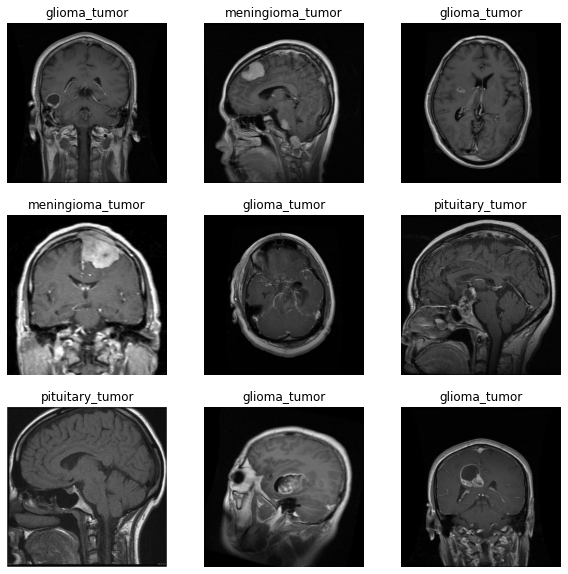

In [55]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [56]:
base_model = tf.keras.applications.Xception(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

# image_batch, label_batch = next(iter(train_ds))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)

83689472/83683744 [==============================] - 20s 0us/step


In [57]:
# Freeze the convolutional base before compile and train the model.
# Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. 
# InceptionResNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them
base_model.trainable = False
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [58]:
# Augment data by randomly flipping it horizontally, and rotations of 0.2
# data_augmentation = tf.keras.Sequential([
#   layers.RandomFlip('horizontal',
#                       input_shape=(img_height,
#                                   img_width,
#                                   3)),
#   layers.RandomRotation(factor=(-0.1, 0.1)),
# ])

# Convert the features to a single 2048-element vector per image
global_average_layer = layers.GlobalAveragePooling2D()
# Prediction layer
prediction_layer = layers.Dense(4, activation='softmax')

In [61]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.xception.preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.2)(x)
# x = layers.Dense(4096, activation='relu')(x)
outputs = prediction_layer(x)
model = Model(inputs, outputs)

model.compile(optimizer=optimizers.Adam(learning_rate=0.003),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_7 (Tenso [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_7 (TensorFlo [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 4096)              8392704   
_________________________________________________________________
dropout_6 (Dropout)          (None, 4096)             

In [62]:
# First 10 epochs fitted without fine tuning
initial_epochs = 10

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
85/85 [==============================] - 554s 7s/step - loss: 1.3254 - accuracy: 0.6619 - val_loss: 0.5433 - val_accuracy: 0.7938
Epoch 2/10
85/85 [==============================] - 572s 7s/step - loss: 0.4807 - accuracy: 0.8116 - val_loss: 0.4805 - val_accuracy: 0.8265
Epoch 3/10
85/85 [==============================] - 572s 7s/step - loss: 0.4076 - accuracy: 0.8510 - val_loss: 0.3994 - val_accuracy: 0.8522
Epoch 4/10
85/85 [==============================] - 572s 7s/step - loss: 0.3412 - accuracy: 0.8716 - val_loss: 0.6000 - val_accuracy: 0.7689
Epoch 5/10
85/85 [==============================] - 571s 7s/step - loss: 0.2951 - accuracy: 0.8904 - val_loss: 0.3614 - val_accuracy: 0.8668
Epoch 6/10
85/85 [==============================] - 572s 7s/step - loss: 0.2389 - accuracy: 0.9102 - val_loss: 0.3761 - val_accuracy: 0.8720
Epoch 7/10
85/85 [==============================] - 574s 7s/step - loss: 0.1958 - accuracy: 0.9235 - val_loss: 0.3901 - val_accuracy: 0.8737
Epoch 8/10
85

In [63]:
# Fine tune all layers now
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [67]:
# Fine-tune from this layer onwards
fine_tune_at = 128

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [68]:
model.compile(optimizer=optimizers.Adadelta(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_7 (Tenso [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_7 (TensorFlo [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 4096)              8392704   
_________________________________________________________________
dropout_6 (Dropout)          (None, 4096)             

In [69]:
len(model.trainable_variables)

8

In [70]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
85/85 [==============================] - 596s 7s/step - loss: 0.1443 - accuracy: 0.9463 - val_loss: 0.4663 - val_accuracy: 0.8505
Epoch 11/20
85/85 [==============================] - 602s 7s/step - loss: 0.1365 - accuracy: 0.9525 - val_loss: 0.4613 - val_accuracy: 0.8531
Epoch 12/20
85/85 [==============================] - 603s 7s/step - loss: 0.1334 - accuracy: 0.9551 - val_loss: 0.4572 - val_accuracy: 0.8548
Epoch 13/20
85/85 [==============================] - 611s 7s/step - loss: 0.1360 - accuracy: 0.9474 - val_loss: 0.4534 - val_accuracy: 0.8574
Epoch 14/20
85/85 [==============================] - 606s 7s/step - loss: 0.1233 - accuracy: 0.9555 - val_loss: 0.4501 - val_accuracy: 0.8591
Epoch 15/20
85/85 [==============================] - 681s 8s/step - loss: 0.1259 - accuracy: 0.9547 - val_loss: 0.4469 - val_accuracy: 0.8617
Epoch 16/20
85/85 [==============================] - 826s 10s/step - loss: 0.1239 - accuracy: 0.9555 - val_loss: 0.4440 - val_accuracy: 0.8625
Epoch

In [ ]:
fine_tune_further_epochs = 10
total_further_epochs =  total_epochs + fine_tune_further_epochs

history_fine_further = model.fit(train_ds,
                                 epochs=total_further_epochs,
                                 initial_epoch=history_fine.epoch[-1],
                                 validation_data=val_ds)

Epoch 20/30
85/85 [==============================] - 618s 7s/step - loss: 0.1146 - accuracy: 0.9643 - val_loss: 0.4323 - val_accuracy: 0.8703
Epoch 21/30
85/85 [==============================] - 651s 8s/step - loss: 0.1211 - accuracy: 0.9562 - val_loss: 0.4304 - val_accuracy: 0.8711
Epoch 22/30
85/85 [==============================] - 658s 8s/step - loss: 0.1091 - accuracy: 0.9599 - val_loss: 0.4286 - val_accuracy: 0.8711
Epoch 23/30
85/85 [==============================] - 655s 8s/step - loss: 0.1064 - accuracy: 0.9603 - val_loss: 0.4269 - val_accuracy: 0.8711
Epoch 24/30
85/85 [==============================] - 651s 8s/step - loss: 0.1112 - accuracy: 0.9628 - val_loss: 0.4253 - val_accuracy: 0.8703
Epoch 25/30
85/85 [==============================] - 651s 8s/step - loss: 0.1084 - accuracy: 0.9566 - val_loss: 0.4238 - val_accuracy: 0.8703
Epoch 26/30
85/85 [==============================] - 649s 8s/step - loss: 0.1108 - accuracy: 0.9584 - val_loss: 0.4224 - val_accuracy: 0.8729
Epoch 

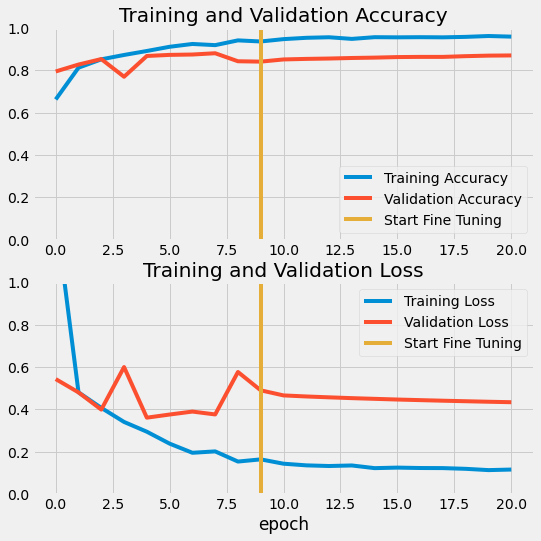

In [71]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

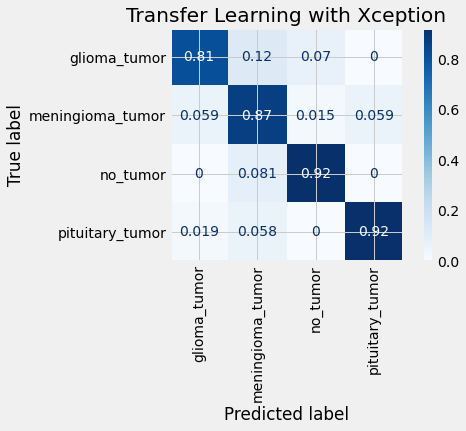

In [73]:
predictions = np.array([])
labels =  np.array([])
for x, y in tqdm(test_ds):
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
  labels = np.concatenate([labels, y.numpy()])
  # labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

disp = metrics.ConfusionMatrixDisplay.from_predictions(
        labels,
        predictions,
        display_labels = test_ds.class_names,
        xticks_rotation = 'vertical',
        cmap=plt.cm.Blues,
        normalize='true'
    )

disp.ax_.set_title('Transfer Learning with Xception')
plt.show

print(metrics.classification_report(
    labels, predictions, target_names=test_ds.class_names))

In [75]:
model_path = './saved_models'
if os.path.exists(model_path):
    print('The directory for saved models already exists')
else:
  os.mkdir(model_path)
model.save(os.path.join(model_path, 'xception_finetuned'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./saved_models\xception_finetuned\assets


In [ ]:
# # AlexNet Implementation
# model = Sequential([
#     data_augmentation,
#     layers.Rescaling(1./255),
#     layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
#     layers.BatchNormalization(),
#     layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#     layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
#     layers.BatchNormalization(),
#     layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#     layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#     layers.BatchNormalization(),
#     layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
#     layers.BatchNormalization(),
#     layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
#     layers.BatchNormalization(),
#     layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#     layers.Flatten(),
#     layers.Dense(4096, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(4096, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(4, activation='softmax')
# ])
